In [15]:
import argparse
import os, sys
import time
import tabulate

import torch
import torch.nn.functional as F
import torchvision

os.sys.path.append("/home/izmailovpavel/Documents/Projects/private_swa_uncertainties")
from swag import data, models, utils, losses
from swag.posteriors import SWAG

from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [16]:
model_cfg = getattr(models, "VGG16")
class_names =  ["airplane", "car", "bird", "cat", "deer", "dog", "monkey", "horse", "ship", "truck"]

In [5]:
x[0].shape

(3, 32, 32)

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Text(0.5, 0.98, 'CIFAR10')

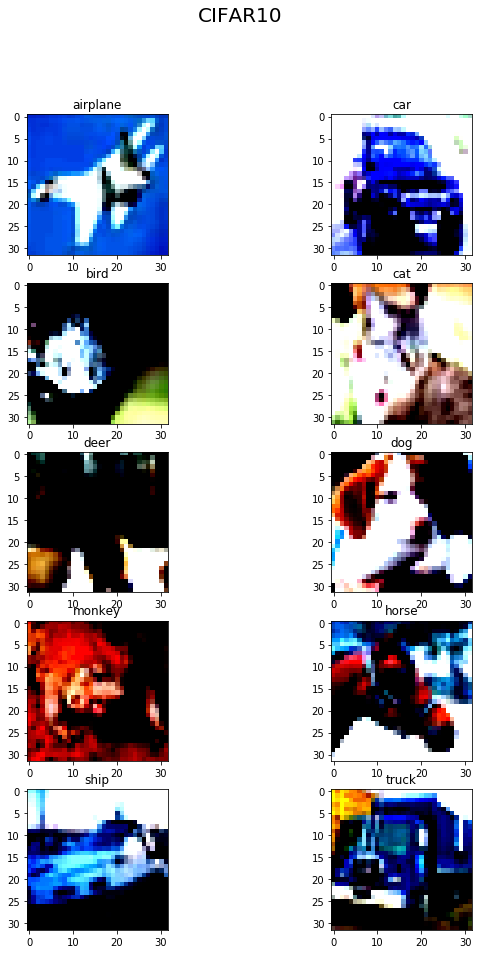

In [7]:
# print('Loading dataset %s from %s' % (, args.data_path))
loaders, num_classes = data.loaders(
#     "STL10",
    "CIFAR10",
    "/home/izmailovpavel/datasets/",
    64,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False,
    split_classes=None
)

# ds = loaders["test"].dataset
# x = ds.test_data
# y = np.array(ds.test_labels)
for x, y in loaders["test"]:
    x = x.numpy().transpose(0,2,3,1)
    y = y.numpy()
    break

f, ax = plt.subplots(5, 2, figsize=(10, 15))
for label in range(10):
    i, j = label // 2, label % 2
    idx = np.where(y == label)[0][1]
    ax[i, j].imshow(x[idx])
    ax[i, j].set_title(class_names[y[idx]])
f.suptitle("CIFAR10", fontsize=20)

TypeError: Traceback (most recent call last):
  File "/home/izmailovpavel/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/izmailovpavel/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/izmailovpavel/.local/lib/python3.5/site-packages/torchvision/datasets/stl10.py", line 108, in __getitem__
    img = self.transform(img)
  File "/home/izmailovpavel/.local/lib/python3.5/site-packages/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/home/izmailovpavel/.local/lib/python3.5/site-packages/torchvision/transforms/transforms.py", line 175, in __call__
    return F.resize(img, self.size, self.interpolation)
  File "/home/izmailovpavel/.local/lib/python3.5/site-packages/torchvision/transforms/functional.py", line 189, in resize
    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
TypeError: img should be PIL Image. Got <class 'torch.Tensor'>


Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 1 is out of bounds for axis 0 with size 1

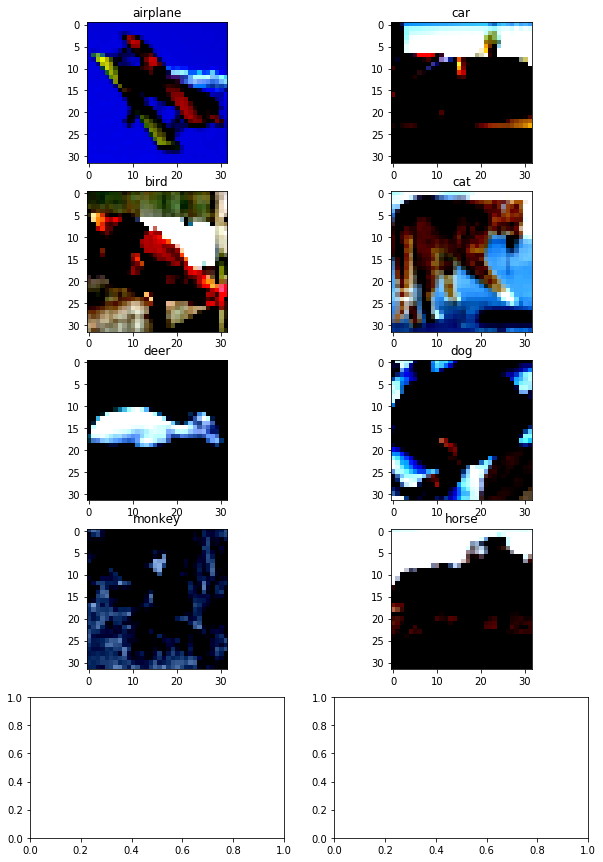

In [8]:
loaders, num_classes = data.loaders(
    "STL10",
    "/home/izmailovpavel/datasets/",
    64,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False,
    split_classes=None
)
    
# ds = loaders["test"].dataset
# ds = loaders["train"].dataset
# x = ds.data
# y = ds.labels
for x, y in loaders["test"]:
    x = x.numpy().transpose(0,2,3,1)
    y = y.numpy()
    break

f, ax = plt.subplots(5, 2, figsize=(10, 15))
for label in range(10):
    i, j = label // 2, label % 2
    idx = np.where(y == label)[0][1]
    ax[i, j].imshow(x[idx])
    ax[i, j].set_title(class_names[y[idx]])

f.suptitle("STL10", fontsize=20)

## Calibration

In [38]:
import numpy as np
import os
os.sys.path.append("../experiments/uncertainty/")
from temp_scaling import optimal_temp_scale, rescale_temp
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
swag_cov = np.load('../ckpts/c10/vgg16/run1/unc_swagcov_stl.npz')
swag = np.load('../ckpts/c10/vgg16/run1/unc_swagdiag_stl.npz')
swa = np.load('../ckpts/c10/vgg16/run1/unc_swa_stl.npz')
sgd = np.load('../ckpts/c10/vgg16/run1/unc_sgd_stl.npz')
swa_drop = np.load('../ckpts/c10/vgg16/run1/unc_swa_drop_stl.npz')
sgd_drop = np.load('../ckpts/c10/vgg16/run1/unc_sgd_drop_stl.npz')
drop = np.load('../ckpts/c10/vgg16/run1/unc_sgd_drop_stl.npz')
swa_val = np.load('../ckpts/c10/vgg16/run1/unc_swa_val.npz')
sgd_val = np.load('../ckpts/c10/vgg16/run1/unc_sgd_val.npz')

In [40]:
T_swa, _ = optimal_temp_scale(swa_val["predictions"], swa_val["targets"], lr=1e-3)
T_sgd, _ = optimal_temp_scale(sgd_val["predictions"], sgd_val["targets"], lr=1e-3)
rescaled_swa = rescale_temp(swa["predictions"], T_swa)
# T_sgd=1
rescaled_sgd = rescale_temp(sgd["predictions"], T_sgd)

Before temperature - NLL: 0.001
After temperature - NLL: 0.001
Before temperature - NLL: 0.308
After temperature - NLL: 0.256


In [41]:
def compute_accuracy_by_entropy(entropy, preds, labels, bins=None):
    if bins is None:
        bins = np.percentile(entropy, np.arange(100))
    digitized = np.digitize(entropy, bins)
    accuracy = [np.sum(preds[digitized==i]==labels[digitized==i])/np.sum(digitized==i) for i in range(1, len(bins))]
    return accuracy, bins

/home/izmailovpavel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


Text(0.5, 1.0, 'CIFAR-10 -> STL, VGG-16')

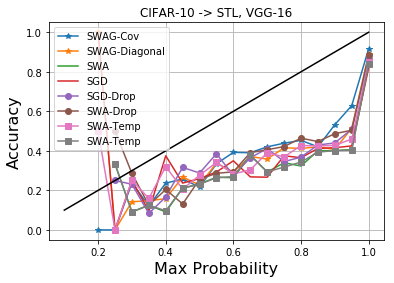

In [42]:
#plt.xscale('log')

acc, bins = compute_accuracy_by_entropy(np.max(swag_cov['predictions'],1), 
                                        np.argmax(swag_cov['predictions'],1), 
                                        swag_cov['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, "-*", label='SWAG-Cov')

acc, bins = compute_accuracy_by_entropy(np.max(swag['predictions'],1), 
                                        np.argmax(swag['predictions'],1), 
                                        swag['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, "-*", label='SWAG-Diagonal')

acc, bins = compute_accuracy_by_entropy(np.max(swa['predictions'],1), 
                                        np.argmax(swa['predictions'],1), 
                                        swa['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='SWA')

acc, bins = compute_accuracy_by_entropy(np.max(sgd['predictions'],1), 
                                        np.argmax(sgd['predictions'],1), 
                                        sgd['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='SGD')

acc, bins = compute_accuracy_by_entropy(np.max(sgd_drop['predictions'],1), 
                                        np.argmax(sgd_drop['predictions'],1), 
                                        sgd_drop['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, "-o", label='SGD-Drop')

acc, bins = compute_accuracy_by_entropy(np.max(swa_drop['predictions'],1), 
                                        np.argmax(swa_drop['predictions'],1), 
                                        swa_drop['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, "-o", label='SWA-Drop')

acc, bins = compute_accuracy_by_entropy(np.max(rescaled_sgd,1), 
                                        np.argmax(rescaled_sgd,1), 
                                        sgd['targets'],
                                        bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, "-s", label='SWA-Temp')

acc, bins = compute_accuracy_by_entropy(np.max(rescaled_swa,1), 
                                        np.argmax(rescaled_swa,1), 
                                        swa['targets'],
                                        bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, "-s", label='SWA-Temp')

plt.plot(np.arange(0.1,1.01,.01), np.arange(0.1,1.01,.01), c='black')

plt.xlabel('Max Probability', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.grid()
plt.legend()
plt.title("CIFAR-10 -> STL, VGG-16")
# plt.savefig('cifar10toSTL10_calibration.pdf')